### LSST AGN SC Classification Example

Gordon Richards and Weixiang Yu, Drexel University, February 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.

It specifically contains example code illustrating Pandas, Matplotlib, and SciKit-Learn tools that can be used to develop intitial selection algorithms for AGN in the LSST context.

Where possible and appropriate, we make reference to [Jake Vanderplas' Handbook for Data Science Python]( https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
## If using SciServer
# See Get_started.ipynb
init()

Start by loading up the quasar and non-AGN databases into [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [3]:
qso_df = get_qso_cat()
qso_df.head(3)

,train_id,ra_sdss,dec_sdss,sdssj,z,z_err,thing_id,specobjid,spec,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,spec2coadd,ra_sp,dec_sp,SPIES_ID,FLUX_AUTO_ch1,FLUXERR_AUTO_ch1,FLUX_AUTO_ch2,FLUXERR_AUTO_ch2,CLASS_STAR_ch1,CLASS_STAR_ch2,sdss2spies,sdss2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,lcN,psPm[0],psPm[1],psParallax,dered_u,dered_g,dered_r,dered_i,dered_z,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z]
0,0,310.0377,-1.005592,204009.04-010020.1,2.167268,0.000676,<NA>,276352159556042752,7,8647475119809364088,19.64425,19.11970,18.69050,18.39786,18.12030,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244396,0.177257,0.134408,0.095297,0.083856,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605913088,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,60,-0.609215,-0.206735,0.225240,19.312095,18.875304,18.513243,18.263452,18.025003,0.436791,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848
1,3,311.6088,0.393812,204626.10+002337.7,0.333015,0.000351,<NA>,537282917827608576,7,8647475121420632840,19.98406,18.87617,17.98685,17.88391,17.11791,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,0.051798,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,69,0.044235,0.075344,-0.149525,19.489293,18.512125,17.722814,17.683700,16.975958,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829
2,4,312.3636,0.718380,204927.25+004306.1,1.699121,0.000973,<NA>,314071864353751040,7,8647475121957832451,21.65874,20.98272,20.43363,19.93146,19.81973,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,0.154056,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360381440,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,54,-0.776679,0.635052,-0.486411,21.131835,20.595028,20.152444,19.718245,19.668558,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902


In [4]:
vstar_df = get_var_cat()
vstar_df.head(3)

,train_id,ivz_id,ra_sdss,dec_sdss,sdss2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_sp,dec_sp,SPIES_ID,FLUX_AUTO_ch1,FLUXERR_AUTO_ch1,FLUX_AUTO_ch2,FLUXERR_AUTO_ch2,CLASS_STAR_ch1,CLASS_STAR_ch2,sdss2spies,objid,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,lcN,psPm[0],psPm[1],psParallax,dered_u,dered_g,dered_r,dered_i,dered_z,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z]
0,100070,74,2.714809,0.963019,0.098278,2546353103253723136,-0.330858,1.105588,0.161619,1.966663,-6.564630,0.950373,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8658188596295368704,20.79964,20.04293,19.78893,19.69865,19.61046,0.074844,0.030475,0.038231,0.049764,0.074923,0.123449,0.090832,0.065879,0.049954,0.035418,38,0.161619,-6.564630,-0.330858,20.676191,19.952098,19.723051,19.648696,19.575042,0.724094,0.229047,0.074355,0.073654,18760.905302,19472.756319,46856.340525,50173.482427,54565.860523
1,100073,429,1.145510,-0.887604,0.089019,2545683333166174720,0.982614,0.271784,13.324682,0.567646,-16.236439,0.230887,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8658170687895109632,21.70556,19.35863,18.00129,17.24292,16.78838,0.161327,0.051916,0.034715,0.013419,0.025616,0.185682,0.136623,0.099091,0.075137,0.053273,14,13.324682,-16.236439,0.982614,21.519878,19.222007,17.902199,17.167783,16.735107,2.297871,1.319807,0.734417,0.432676,8603.466401,8943.271578,250694.695652,493074.367005,748131.196335
2,100074,551,2.315915,0.587049,0.151650,2546314177963575296,0.803362,0.172930,-0.503402,0.280889,-10.100079,0.187837,2.315877,0.587073,3085374,312.98757,3.372453,195.15914,3.132563,0.979983,0.971256,0.163383,8658195605165309952,20.80007,18.37660,17.54425,17.12750,16.79773,0.081718,0.023560,0.016964,0.016918,0.015532,0.149893,0.110290,0.079991,0.060655,0.043005,51,-0.503402,-10.100079,0.803362,20.650177,18.266310,17.464259,17.066845,16.754725,2.383867,0.802052,0.397414,0.312120,19216.458878,19945.221810,375251.291284,541112.565829,734734.252916


Actually, better yet, let's load both the quasars and non-AGNs into a single DataFrame, where the class is indicated by `qlabel`.  This will make our lives easier in terms of getting the training data into the format that [SciKit-Learn](https://scikit-learn.org/stable/index.html) prefers.

In [5]:
all_df = get_train_cat()
all_df.head(5)

,CLASS_STAR_ch1,CLASS_STAR_ch2,FLUXERR_AUTO_ch1,FLUXERR_AUTO_ch2,FLUX_AUTO_ch1,FLUX_AUTO_ch2,SPIES_ID,dec_sdss,dec_sp,dered_g,dered_i,dered_r,dered_u,dered_z,extinction_g,extinction_i,extinction_r,extinction_u,extinction_z,gaia_id,ivz_id,lcN,objid,parallax,parallax_error,pmdec,pmdec_error,pmra,pmra_error,psFlux[g],psFlux[i],psFlux[r],psFlux[u],psFlux[z],psParallax,psPm[0],psPm[1],psfmag_g,psfmag_i,psfmag_r,psfmag_u,psfmag_z,psfmagerr_g,psfmagerr_i,psfmagerr_r,psfmagerr_u,psfmagerr_z,qlabel,ra_sdss,ra_sp,sdss2gaia,sdss2spies,sdssj,spec,spec2coadd,specobjid,stdColor[0],stdColor[1],stdColor[2],stdColor[3],thing_id,train_id,z,z_err
0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,-1.005592,NaN,18.875304,18.263452,18.513243,19.312095,18.025003,0.244396,0.134408,0.177257,0.332155,0.095297,4226318531605913088,<NA>,60,8647475119809364088,0.225240,0.283972,-0.206735,0.305267,-0.609215,0.464463,68419.255122,179737.984132,142798.907734,65942.328054,228014.565848,0.225240,-0.609215,-0.206735,19.11970,18.39786,18.69050,19.64425,18.12030,0.003265,0.002969,0.003569,0.008446,0.005960,1,310.0377,NaN,0.024083,NaN,204009.04-010020.1,7,0.083856,276352159556042752,0.436791,0.362060,0.249792,0.238449,<NA>,0,2.167268,0.000676
1,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.393812,NaN,18.512125,17.683700,17.722814,19.489293,16.975958,0.364045,0.200210,0.264036,0.494767,0.141952,4228017414511443968,<NA>,69,8647475121420632840,-0.149525,0.160723,0.075344,0.179892,0.044235,0.275073,58115.957521,306580.434350,295732.889174,56011.332155,599285.639829,-0.149525,0.044235,0.075344,18.87617,17.88391,17.98685,19.98406,17.11791,0.001996,0.002298,0.001869,0.011383,0.003088,1,311.6088,NaN,0.092993,NaN,204626.10+002337.7,7,0.051798,537282917827608576,0.977168,0.789311,0.039115,0.707741,<NA>,3,0.333015,0.000351
2,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.718380,NaN,20.595028,19.718245,20.152444,21.131835,19.668558,0.387692,0.213215,0.281186,0.526905,0.151172,4228378535360381440,<NA>,54,8647475121957832451,-0.486411,0.729782,0.635052,1.033818,-0.776679,2.051325,12794.084912,47059.204593,31547.575429,12319.895839,50039.124902,-0.486411,-0.776679,0.635052,20.98272,19.93146,20.43363,21.65874,19.81973,0.009041,0.007637,0.007869,0.037532,0.022191,1,312.3636,NaN,0.218568,NaN,204927.25+004306.1,7,0.154056,314071864353751040,0.536807,0.442585,0.434199,0.049687,<NA>,4,1.699121,0.000973
3,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.834625,NaN,20.042354,19.652183,19.884427,20.403761,19.501243,0.382986,0.210627,0.277773,0.520510,0.149337,<NA>,<NA>,118,8647475121957831705,NaN,NaN,NaN,NaN,NaN,NaN,25029.261444,50012.543099,40383.598908,24118.091101,58422.366330,NaN,NaN,NaN,20.42534,19.86281,20.16220,20.92427,19.65058,0.005620,0.007393,0.006083,0.020328,0.019640,1,312.4020,NaN,NaN,NaN,204936.47+005004.6,7,0.160105,314071864311808000,0.361406,0.157927,0.232244,0.150940,<NA>,5,0.475306,0.000354
4,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0.455123,NaN,20.005581,19.760675,19.965770,19.954390,19.543730,0.338089,0.185935,0.245210,0.459490,0.131831,4228358022596118528,<NA>,54,8647474692461166737,0.250211,0.772921,-0.107082,1.024258,1.965712,2.234255,37865.005535,45254.921252,37467.915153,36491.532269,56170.337863,0.250211,1.965712,-0.107082,20.34367,19.94661,20.21098,20.41388,19.67556,0.005312,0.007587,0.006064,0.013942,0.019144,1,312.4340,NaN,0.100156,NaN,204944.16+002718.4,7,0.150507,314353417491316736,-0.051192,0.039811,0.205095,0.216945,<NA>,6,2.080289,0.001066


What columns are available to us?

In [6]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49528 entries, 0 to 49527
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CLASS_STAR_ch1    8874 non-null   float64
 1   CLASS_STAR_ch2    8874 non-null   float64
 2   FLUXERR_AUTO_ch1  8874 non-null   float64
 3   FLUXERR_AUTO_ch2  8874 non-null   float64
 4   FLUX_AUTO_ch1     8874 non-null   float64
 5   FLUX_AUTO_ch2     8874 non-null   float64
 6   SPIES_ID          8874 non-null   Int64  
 7   dec_sdss          49528 non-null  float64
 8   dec_sp            8874 non-null   float64
 9   dered_g           49528 non-null  float64
 10  dered_i           49528 non-null  float64
 11  dered_r           49528 non-null  float64
 12  dered_u           49528 non-null  float64
 13  dered_z           49528 non-null  float64
 14  extinction_g      49528 non-null  float64
 15  extinction_i      49528 non-null  float64
 16  extinction_r      49528 non-null  float6

Note that the different features/attributes/columns in the dataframe have different numbers of non-null entries.  One has to decide how to handle these.  Either by dropping objects with nulls, dropping columns with too many nulls, or replacing the null values with some sort of average (so that that objects or column can still be used even if that feature is not accurate).

Note also the use of `stdColor[0]` etc, which is the way that "colors" are stored in the current [LSST Data Model](https://lse-163.lsst.io/).  Unfortunately, one of the few downsides of Pandas is that it can't handle vectors columns like this, so they are currently split up in a way that is somewhat awkward.

For now, let's just use the columns in the following cell.  In the end, we'll use many more features than this (and we'll want to include columns that parameterize the variability -- if not use the light curves directly), but this combines features of different types from different sources, which is what we want to illustrate here.

In [7]:
collist = ['ra_sdss','dec_sdss','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','parallax','pmra','pmdec','qlabel']
train_df = all_df[collist]

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49528 entries, 0 to 49527
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra_sdss      49528 non-null  float64
 1   dec_sdss     49528 non-null  float64
 2   stdColor[0]  49528 non-null  float64
 3   stdColor[1]  49528 non-null  float64
 4   stdColor[2]  49528 non-null  float64
 5   stdColor[3]  49528 non-null  float64
 6   parallax     33612 non-null  float64
 7   pmra         33612 non-null  float64
 8   pmdec        33612 non-null  float64
 9   qlabel       49528 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 3.8 MB


That still leaves us with some features with null values.  For now, let's drop those objects.  [Other options](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html) are also available.

In [9]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33612 entries, 0 to 49527
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra_sdss      33612 non-null  float64
 1   dec_sdss     33612 non-null  float64
 2   stdColor[0]  33612 non-null  float64
 3   stdColor[1]  33612 non-null  float64
 4   stdColor[2]  33612 non-null  float64
 5   stdColor[3]  33612 non-null  float64
 6   parallax     33612 non-null  float64
 7   pmra         33612 non-null  float64
 8   pmdec        33612 non-null  float64
 9   qlabel       33612 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  "y" are the classes for each of those objects.

We'll next build both "y" and "X" (the order is important) from our training dataframe.  

"y" is just the values of `qlabel`.  Note that Pandas dataframes have meta data associated with them.  Using the `values` attribute extracts just the numbers, which is what SciKit-Learn wants.

Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Note that we haven't dropped the RA and Dec from X.  They probably aren't that useful, but they shouldn't hurt either.

In [10]:
y = train_df['qlabel'].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
X = train_df.drop('qlabel',axis=1).values
X
print(X.shape)

(33612, 9)


We'll start with a really simple classification algorithm, [K-Nearest Neighbors (or KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).  It doesn't produce the best results, but it is a decent choice for illustrating a few concepts.

The rest of this notebook will follow the [example from Jake's book](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), but using the data from the AGN training set.

In [12]:
#Import the algorithm
from sklearn.neighbors import KNeighborsClassifier
#Now instantiate the model, here using the closest "neighbor" (the object itself!).
#See the link above for other arguments.
model = KNeighborsClassifier(n_neighbors=1)

In [13]:
#Use the training data to fit the model
model.fit(X, y)

#Now predict the class for a set of test objects.
#(Here just the same objects we trained on, so
#we expect it to be perfect!)
y_pred = model.predict(X)

In [14]:
#Use sklearn's metric to compute a score telling us how well this worked.
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

1.0

To get a more realistic idea of how this model would perform on real data (where we don't know the answer), we split the training set into pieces, treating one piece as the training set and one piece as the test set.  We start with a 50-50 split, but later will use an 80-20 split repeated 5 times (to allow all of the training data to both be used in training the algorithm and also for prediction -- but not at the same time).  The function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) makes this easier for us.

In [15]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_pred = model.predict(X2)
accuracy_score(y2, y2_pred)

0.9191955254075925

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores.mean()

0.8026352846563173

So, this algorithm is about 80% accurate.

If we want to make some plots to see where things are going wrong, then we can use [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) to get the predicted class for each object in the training set (without allowing that object to be used in its own prediction).

In [17]:
from sklearn.model_selection import cross_val_predict
model = KNeighborsClassifier(n_neighbors=9)
y_pred = cross_val_predict(model, X, y, cv=5)

We can then output a [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), which tells us the number of true negatives (non-AGN classified as such), false positives (non-AGN classified as quasars), false negatives (quasars classified as non-AGN) and true positives (quasars classified as such).

In [18]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
(tn, fp, fn, tp)

(18700, 4787, 1070, 9055)

We can also generate a [classification_report]() based on this information, where "precision" is the same a "completeness", and "recall" is the same as "efficiency".  F1 is defined as $2 * (precision * recall) / (precision + recall)$.

In [19]:
from sklearn.metrics import classification_report
target_names=['quasars','non-AGN']
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     quasars       0.95      0.80      0.86     23487
     non-AGN       0.65      0.89      0.76     10125

    accuracy                           0.83     33612
   macro avg       0.80      0.85      0.81     33612
weighted avg       0.86      0.83      0.83     33612



We can also make some plots to try to see where things are going wrong (or right).

In [20]:
#Make masks for the above to aid in plotting
tpmask = ((y==1) & (y_pred==1))
tnmask = ((y==0) & (y_pred==0))
fpmask = ((y==0) & (y_pred==1))
fnmask = ((y==1) & (y_pred==0))
print(train_df[tpmask]['stdColor[0]'])

38       0.112551
45      -0.241861
81       0.171694
86       0.173809
87       0.011346
           ...   
24572    0.146124
24573    0.229341
24574    0.183699
24576    0.672808
24578    0.375685
Name: stdColor[0], Length: 9055, dtype: float64


Text(0, 0.5, 'parallax')

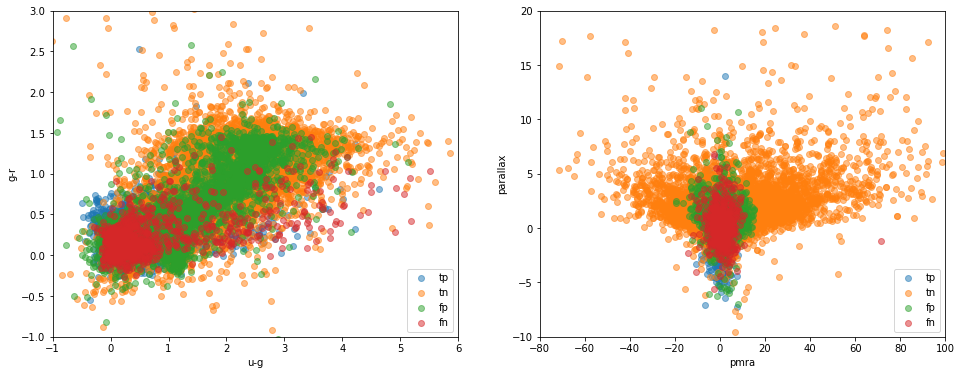

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(train_df[tpmask]['stdColor[0]'],train_df[tpmask]['stdColor[1]'],label='tp',alpha=0.5)
ax[0].scatter(train_df[tnmask]['stdColor[0]'],train_df[tnmask]['stdColor[1]'],label='tn',alpha=0.5)
ax[0].scatter(train_df[fpmask]['stdColor[0]'],train_df[fpmask]['stdColor[1]'],label='fp',alpha=0.5)
ax[0].scatter(train_df[fnmask]['stdColor[0]'],train_df[fnmask]['stdColor[1]'],label='fn',alpha=0.5)
ax[0].legend(loc='lower right')
ax[0].set_xlim(-1,6)
ax[0].set_ylim(-1,3)
ax[0].set_xlabel('u-g')
ax[0].set_ylabel('g-r')

ax[1].scatter(train_df[tpmask]['pmra'],train_df[tpmask]['parallax'],label='tp',alpha=0.5)
ax[1].scatter(train_df[tnmask]['pmra'],train_df[tnmask]['parallax'],label='tn',alpha=0.5)
ax[1].scatter(train_df[fpmask]['pmra'],train_df[fpmask]['parallax'],label='fp',alpha=0.5)
ax[1].scatter(train_df[fnmask]['pmra'],train_df[fnmask]['parallax'],label='fn',alpha=0.5)
ax[1].legend(loc='lower right')
ax[1].set_xlim(-80,100)
ax[1].set_ylim(-10,20)
ax[1].set_xlabel('pmra')
ax[1].set_ylabel('parallax')

Obviously these plots aren't very helpful as presented, it would help if we turned the scatter plot into contour plots, but you get the idea.

In the cases above, we just picked the nearest neighbor, but the number of neighbors to look at is a free parameter.  This is the case with many machine learning algorithms, so let's make that a free parameter in our analysis.  In most cases, increasing the number of free parameters will lead to better classification of the training set, but not actually better classification for an unknown data set. We'll use a [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) from sklearn's [model_selection] (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) to help us to estimate the optimal number of neighbors (where the "validation curve" peaks).


In [22]:
from sklearn.model_selection import validation_curve
n = [1,3,9,27,54,162] #Number of neighbors to try.
train_score, val_score = validation_curve(KNeighborsClassifier(), X, y,
                                          param_name='n_neighbors', param_range=n, cv=5)

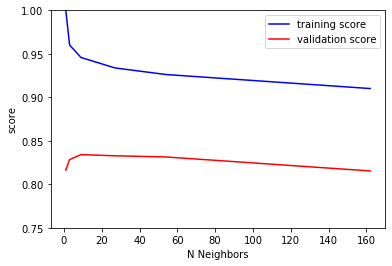

In [23]:
plt.plot(n, np.median(train_score, 1), color='blue', label='training score')
plt.plot(n, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.75, 1)
plt.xlabel('N Neighbors')
plt.ylabel('score');

So, something like 10 nearest neighbors gives the best result (highest validation score).

Next we'll investigate the impact of the size of the training set.  Too little training data is bad, but it isn't obvious that adding more training data will always improve our results.  Plotting a [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) helps us to judge whether or not that is the case.

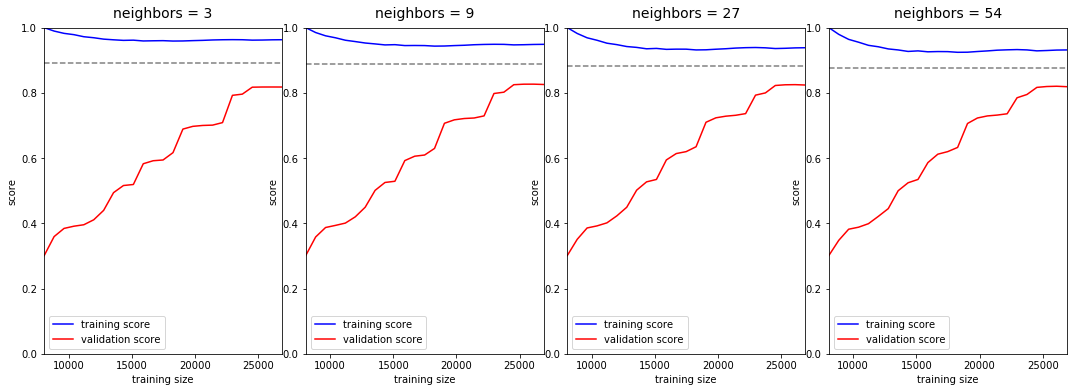

In [24]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 4, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, n in enumerate([3, 9, 27, 54]):
    N, train_lc, val_lc = learning_curve(KNeighborsClassifier(n), X, y, cv=5, \
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('neighbors = {0}'.format(n), size=14)
    ax[i].legend(loc='best')

Here we see that, regardless of the number of neighbors considered, we are generally gaining as we add training data, but we might not expect to gain too much by adding even more training data (at least for a model with this level of complexity).

In the validation_curve example above, we had just one free parameter, but your model may have a number of free parameters that can be varied.  In that case we can use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to optimize all of the parameters.

In the case below we will consider multiple algorithms, multiple weights (both discrete choices), and multiple neighbors (which can be "continuous").

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'algorithm':('kd_tree', 'ball_tree', 'brute'), 'weights':('uniform', 'distance'), \
              'n_neighbors':[3, 9, 27, 54, 162]}

grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)

In [26]:
grid.fit(X, y);

After instantiating the model(s) we fit the training set and extract the best-fit parameters using the `best_params_` attrribute.

In [27]:
grid.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'}

Now we can instantiate a model with those best-fit parameters and apply it to unknown data.

In [28]:
#Instantiate a model with those parameters.
model = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree', weights='uniform')

In [29]:
#Run in on some data.  Here it is the training data and not unknown data, 
#so the result isn't independent of the training set.
scores=cross_val_score(model, X, y, cv=5)
scores.mean()

0.8257523775333186

In [30]:
#How to then predict on new data
#ytestpred = model.fit(Xtest)

We'll quickly try using a different classifier and see how much better that might do.  In this case we'll use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
model = RandomForestClassifier(n_estimators=200)

In [33]:
#N.B., this takes a few minutes
scores=cross_val_score(model, X, y, cv=5)
scores.mean()

0.9036387320359269

The RF does much better than the KNN -- even after we optimized the parameters of the KNN.  Clearly, we'll need to try lots of algorithms, add more features to the training set, including "engineering" some of those features (e.g., parameterizing the variability as determined from the light curves).